In [65]:
# !pip install import-ipynb
# !pip install qiskit_experiments
# !pip install kaleidoscope
# !pip install qiskit_aer
# !pip install qiskit-ibm-runtime
# !pip install qiskit_experiments

In [66]:

 
# Save an IBM Quantum account and set it as your default account.
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="dce7416f1a1521e83858fa10bc025106c1829f51393a261864b78ad0416da569d5e4811ae612809d4742c8793409ddd85ed94a33d53b42589ecdd3a092e6f592", set_as_default=True,overwrite=True)
 
# Load saved credentials
# service = QiskitRuntimeService()

## Importación de Librerías

In [1]:
# # Importing standard Qiskit libraries
# from qiskit import  IBMQ


# # Loading your IBM Quantum account(s)
# provider = IBMQ.load_account()
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
service = QiskitRuntimeService()
# Import Qiskit classes
from qiskit import *
import qiskit.quantum_info as qi
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
# from qiskit.providers.aer import noise
import statsmodels.api as sm
#LIBRERÍAS PARA TODO LO NECESARIO: 
#!pip install qiskit ipywidgets    correr esta línea de primero si se trabaja en google collab

#Tomografía de estado 
from qiskit_experiments.library import StateTomography
## Simuladores 
from qiskit_aer import AerSimulator, qasm_simulator
from qiskit.providers.fake_provider import *



from matplotlib import *
%matplotlib inline

#Se importan clases y funciones necesarias para la tomografía
import qiskit.quantum_info as qi
from qiskit.compiler import assemble
import numpy as np 

# Librerías estandar de qiskit
from qiskit.compiler import transpile, assemble
# from qiskit.tools.jupyter import *
# from qiskit.tools.monitor import job_monitor
# from qiskit.visualization import *
# from ibm_quantum_widgets import *
from qiskit.quantum_info import Operator, Choi,Chi, partial_trace,process_fidelity
# from qiskit.extensions import Initialize
import import_ipynb
# from qiskit.tools.visualization import plot_state_city
import pandas as pd 

# import funciones_tesis as funcs
from Funciones_tessis import *
from qiskit_experiments.library.tomography.qpt_experiment import ProcessTomography, ProcessTomographyAnalysis
# from funciones_tesis import *
#Para dibujar sobre la esfera de bloch
# from kaleidoscope import bloch_sphere
#Extración
import scipy
from scipy.stats import lognorm
import scipy.stats as stats
import re 
import collections as colect
import matplotlib.pyplot as plt
# from kaleidoscope import bloch_sphere
import seaborn as sns

from qiskit_aer.noise import depolarizing_error

## Designación de Ansatz para implementación de canales cuánticos en CC
Para implementar un canal cuántico utilizando Algoritmos Variacionales Cuánticos (VQA), proponemos implementar el el ansatz usado en el trabajo previo de prácticas (https://arxiv.org/pdf/2001.02552.pdf, https://arxiv.org/pdf/1905.10876.pdf. ). 

Este ansatz supone un conjunto de rotaciones $Rx,Rz y Cry$ que pueden ser optimizadas para resolver distintos problemas relacionados a información y computación cuántica. Por lo tanto, aquí buscamos optimizar el ansatz de forma que su acción sobre un estado $\rho$ sea similar al de un canal cuántico objetivo. 

Para realizar esta optimización, proponemos una función de costo $c(\theta) = Fidelidadproceso ( \Lambda_{obj} , \Lambda_{rec})$ , donde $\Lambda$ se le conoce como al matriz de Choi perteneciente al canal cuántico a evaluar. Esta matriz se construye aplicando el canal cuántico a un subsistema del  estado máximamente entrelazado según la dimensión del canal. Se describe por la ecuación :

<img src="choi_def.png">

Por ende, para obtener la matriz de Choi de un canal cuántico de un qubit, tenemos $\Lambda_\epsilon$ =  $(\mathbb{I} \otimes \epsilon)[| \phi^+\geq \leq \phi^+|   ]  $.

Al tener este concepto claro y la función de costo definida, procedemos a ejecutar tomografía de proceso usando el ansatz aplicado a un subsistema del estado máximamente entrelazado, posteriormente se optimiza iterativamente la función de costo hasta obtener una Fidelidad de Proceso cercana a 1. Todo este proceso constituye un VQA. Sin embargo, por motivos de eficiente y cola de uso, se hizo esta optimizaicón en el simulador cuántico Qiskit AerSimulator. 

### Visualización del Ansatz a Optimizar

In [2]:
qc= QuantumCircuit(4)
# qc.h(0)
# qc.cx(0, 1)
# qc.barrier(0,1,2,3)
qc_combo = cirq_ansq(2,np.linspace(1,16),1)[0]

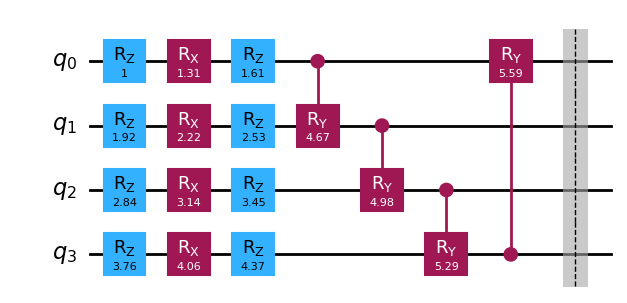

In [3]:
qc_combo.draw('mpl')

In [4]:
def optimizar_depolarizacion(p_values):
    """
    Optimiza la depolarización para una lista de valores de p y devuelve un DataFrame con los resultados.

    :param p_values: Lista de valores de p para optimizar.
    :return: DataFrame con los valores de p, la fidelidad optimizada y los parámetros optimizados.
    """
    results = []
    
    backend = AerSimulator()

    for p in p_values:
        print("Trabajando con p =", p)
        target = choi_matrix_depolarizing(p)  # Genera la matriz objetivo para el valor de p
        
        def cost_func(params):
            '''
            Función de costo para hallar la matriz densidad objetivo. 
            
            Entradas:
                Globales: 
                    qubits: int
                        número de qubits a usar en el circuito. 
                    layers: int
                        número de capas a usar en el circuito. 
                    target: array, float
                        matriz densidad objetivo 
                Locales: 
                    params:float,array
                        parametros theta, correspondientes a las rotaciones a usar. 
            '''
            qc_combo = cirq_ansq(2, params, 1)[0]
            tomo_circuits = ProcessTomography(circuit=qc_combo, measurement_indices=[0], preparation_indices=[0])
            stdata = tomo_circuits.run(backend).block_for_results()
            choi_dens = stdata.analysis_results("state").value    
            # print(target)
            cost = -process_fidelity(target, choi_dens)  # Se compara la fidelidad y luego se obtiene el negativo para ser minimizado. 
            # print(cost*-1)
            return cost

        # Realiza la optimización
        opt_depolarizing = scipy.optimize.minimize(cost_func, np.random.rand(16) * 2 * np.pi, method='COBYLA', options={'maxiter': 1200, 'tol': 1e-15})
        
        # Almacena el resultado de esta iteración
        params = opt_depolarizing.x
        qc_combo = cirq_ansq(2, params, 1)[0]
        tomo_circuits = ProcessTomography(circuit=qc_combo, measurement_indices=[0], preparation_indices=[0])
        stdata = tomo_circuits.run(backend).block_for_results()
        choi_dens = stdata.analysis_results("state").value    
        prresultado_0 = process_fidelity(target, choi_dens)
        
        results.append({'p': p, 'x': params, 'choi_dens': choi_dens, 'Fidelidad': prresultado_0})
    
    # Convierte la lista de resultados en un DataFrame
    df_results = pd.DataFrame(results)
    
    # Opcional: expandir la columna 'x' en múltiples columnas para cada elemento de x
    x_df = pd.DataFrame(df_results['x'].tolist(), index=df_results.index)
    x_df.columns = [f'x{i}' for i in range(x_df.shape[1])]  # Nombrar las columnas como x0, x1, ...
    
    # Concatenar los DataFrames para tener una sola estructura de datos k
    df_results = pd.concat([df_results.drop(columns=['x']), x_df], axis=1)
    
    return df_results

# # Ejemplo de uso
# p_values = [0.125,0.175,0.225,0.275,0.325,0.375,0.425,0.475,0.525,0.575,0.625,0.675,0.725,0.775,0.825,0.875,0.925,0.95,0.975]
# df_results_7 = optimizar_depolarizacion(p_values)


In [1]:
def optimizar_depolarizacion(p_values):
    """
    Optimiza la depolarización para una lista de valores de p y devuelve un DataFrame con los resultados.

    :param p_values: Lista de valores de p para optimizar.
    :return: DataFrame con los valores de p, la fidelidad optimizada y los parámetros optimizados.
    """
    results = []
    
    backend = AerSimulator()

    for p in p_values:
        print("Trabajando con p =", p)
        target = choi_matrix_depolarizing(p)  # Genera la matriz objetivo para el valor de p
        
        # Realiza la optimización
        # print(target)
        opt_depolarizing = scipy.optimize.minimize(cost_func, np.random.rand(8)*2*np.pi, method='COBYLA', options={'maxiter':1000, 'tol':0.00000000001})
        
        # Almacena el resultado de esta iteración
        params = opt_depolarizing.x
        # print(target)
        # Crear el circuito cuántico y realizar la tomografía de procesos
        # qc = QuantumCircuit(2)
        # qc.h(0)
        # qc.cx(0, 1)
        # qc.barrier(0,1,2,3)
        
        # qc_combo = qc.compose(cirq_ansq(2, params, 1)[0])
        qc_combo = cirq_ansq(1, params, 1)[0]
        
        tomo_circuits = ProcessTomography(circuit=qc_combo, measurement_indices=[0], preparation_indices=[0])
        stdata = tomo_circuits.run(backend).block_for_results()
        choi_dens = stdata.analysis_results("state").value    
        
        prresultado_0 = process_fidelity(target, choi_dens)
        
        results.append({'p': p, 'x': params, 'choi_dens': choi_dens, 'Fidelidad': prresultado_0})
    
    # Convierte la lista de resultados en un DataFrame
    df_results = pd.DataFrame(results)
    
    # Opcional: expandir la columna 'x' en múltiples columnas para cada elemento de x
    x_df = pd.DataFrame(df_results['x'].tolist(), index=df_results.index)
    x_df.columns = [f'x{i}' for i in range(x_df.shape[1])]  # Nombrar las columnas como x0, x1, ...
    
    # Concatenar los DataFrames para tener una sola estructura de datos
    df_results = pd.concat([df_results.drop(columns=['x']), x_df], axis=1)
    
    return df_results

def cost_func(params):
    '''
    Función de costo para hallar la matriz densidad objetivo. 
    
    Entradas:
        Globales: 
            qubits: int
                número de qubits a usar en el circuito. 
            layers: int
                número de capas a usar en el circuito. 
            target: array, float
                matriz densidad objetivo 
        Locales: 
            params:float,array
                parametros theta, correspondientes a las rotaciones a usar. 
    
    '''
    
    
    # Dens= cirq_ansq(2,params,1)[1] #Genera un dummy circuit
    # qc=QuantumCircuit(2)
    # qc.h(0)
    # qc.cx(0, 1)
    # qc.barrier(0,1,2,3)
    qc_combo = (cirq_ansq(1,params,1)[0])
    # qc_combo = qc.compose(cirq_ansq(2,params,1)[0])
    # qc_combined = cirq_ansq(1,params,1)[0]
    # depola(1)
    backend = AerSimulator()
    tomo_circuits = ProcessTomography(circuit=qc_combo,
                                measurement_indices=[0],
                                 preparation_indices=[0],
                                     )
    stdata = tomo_circuits.run(backend).block_for_results()
    choi_dens = stdata.analysis_results("state").value    
    print(target)
    cost=-process_fidelity(target,choi_dens)  #Se compara la fidelidad y luego se obtiene el negativo para ser minimizado. 
    print(process_fidelity(target,choi_dens))
    costo.append(cost*-1)
    return cost




In [41]:
p_values=[0.01]
# costo=[]
target=choi_matrix_depolarizing(0.01)
df_results_5 = optimizar_depolarizacion(p_values)

In [9]:
def depolarizing(p):
    #Se usa la rotación theta como la parametrización de p 
    theta =  1/2 * np.arccos(1-2*p)
    
    #Implementación del circuit 
    cuantar=QuantumCircuit(4)
    cuantar.ry(theta,0)
    cuantar.ry(theta,2)
    cuantar.ry(theta,3)
    cuantar.cx(0,1)
    cuantar.cy(2,1)
    cuantar.cz(3,1)
    return cuantar

In [177]:
target = choi_matrix_depolarizing(0.69)
# qc = QuantumCircuit(4)
# qc.h(0)
# qc.cx(0, 1)
# qc.barrier(0,1,2,3)
# # qc = (cirq_ansq(2,params,1)[0])
# qc_combo = qc.compose(depolarizing(0.48))

# backend = AerSimulator()
tomo_circuits = ProcessTomography(circuit=depolarizing(0.69),
                                measurement_indices=[1],
                                 preparation_indices=[1],target=target
                                     )
backend=AerSimulator()
stdata = tomo_circuits.run(backend).block_for_results()
choi_dens =  stdata.analysis_results("state").value    

prresultado_0 = process_fidelity(target,choi_dens)  #Se compara la fidelidad y luego se obtiene el negativo para ser minimizado. 
prresultado_0
       

0.9971550146909101

In [ ]:

# Choi(depolarizing_error(0.2, 1))
# choi_matrix_depolarizing(0.1)

## Ejecución en Computadoras Cuánticas

In [133]:
df_final = pd.read_pickle("df_depolarizing_finalizado_01-06-2024")

In [135]:
df_final = df_final.rename(columns={"Choi_sim":"Choi_sim_1"})

In [158]:
service = QiskitRuntimeService()

In [159]:
backend = service.backend(name="ibm_kyoto")
# backend=AerSimulator()

In [140]:
"""
Código para ejecutar en batch y añadir datos iterativamente al dataframe, usar únicamente si no hay retraso en ejecución en la computadora cuántica. 

"""
# Lista de valores de p
p_values = list(df_final.p)  # Añade todos los valores de p que quieras iterar

# Backend
backend = AerSimulator()

# Iterar sobre cada valor de p
for p in p_values:
    target = choi_matrix_depolarizing(p)
    i = df_final[df_final.p == p].index[0]
    
    qc_combo = cirq_ansq(
        2,
        [
            df_final.x0[i],
            df_final.x1[i],
            df_final.x2[i],
            df_final.x3[i],
            df_final.x4[i],
            df_final.x5[i],
            df_final.x6[i],
            df_final.x7[i],
            df_final.x8[i],
            df_final.x9[i],
            df_final.x10[i],
            df_final.x11[i],
            df_final.x12[i],
            df_final.x13[i],
            df_final.x14[i],
            df_final.x15[i],
        ],
        1
    )[0]
    
    tomo_circuits = ProcessTomography(
        circuit=qc_combo,
        measurement_indices=[0],
        preparation_indices=[0],
    )
    
    stdata = tomo_circuits.run(backend).block_for_results()
    choi_dens = stdata.analysis_results("state").value
    prresultado_0 = process_fidelity(target, choi_dens)
    
    a = pd.DataFrame({'p': [p], 'Fidelidad_sim': prresultado_0, 'Choi_sim': choi_dens})
    
    # Asegurarse de que los DataFrames tienen un índice alineado
    df_final.set_index('p', inplace=True)
    a.set_index('p', inplace=True)
    
    # Concatenar los DataFrames en las columnas deseadas
    df_final = df_final.combine_first(a)
    df_final = df_final.reset_index()

# Guardar los resultados finales
# df_final.to_pickle("resultados1-1-06-24")

Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00994124  0.00994124]
Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00604559  0.00604559]
Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00051066  0.00051066]
Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0074791  0.0074791]
Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00726586  0.00726586]
Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00603472  0.00603472]
Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0053191  0.0053191]


In [57]:
"""
Código para ejecución individual . Usar cuando haya retraso en la qc
"""
p=0.225
target = choi_matrix_depolarizing(p)
i = df_final[df_final.p==p].index[0]
qc_combo = cirq_ansq(2,
                                [df_final.x0[i],
                                df_final.x1[i],
                                df_final.x2[i],
                                df_final.x3[i],
                                df_final.x4[i],
                                df_final.x5[i],
                                df_final.x6[i],
                                df_final.x7[i],           
                                df_final.x8[i],  
                                df_final.x9[i],  
                                df_final.x10[i],  
                                df_final.x11[i],  
                                df_final.x12[i],  
                                df_final.x13[i],          
                                df_final.x14[i],    
                                df_final.x15[i]],              
                                1)[0]
# backend = backend
backend=AerSimulator()
tomo_circuits = ProcessTomography(circuit=qc_combo,
                                measurement_indices=[0],
                                 preparation_indices=[0],
                                     )
stdata = tomo_circuits.run(backend).block_for_results()
choi_dens = stdata.analysis_results("state").value    

prresultado_0 = process_fidelity(target,choi_dens)  #Se compara la fidelidad y luego se obtiene el negativo para ser minimizado. 
prresultado_0

0.9717802758194684

In [36]:
a = pd.DataFrame({'p': [p], 'Fidelidad_qc': prresultado_0 , 
 'Choi_qc':choi_dens,'QC':qc_combo,'Choi_obj': target })

In [59]:
# Asegurarse de que los DataFrames tienen un índice alineado
df_final.set_index('p', inplace=True)
a.set_index('p', inplace=True)

# Concatenar los DataFrames en las columnas deseadas
df_final2 = df_final.combine_first(a)
df_final2 = df_final2.reset_index()

df_final2.to_pickle("resultados1-1-06-24")
df_final = df_final2

## Visualización de Resultados para Depolarizing Channel

Se hizo la primera iteración usando VQA para iniciar el canal de depolarización sobre un qubit. Para esto se generaba la matriz de choi del canal para cada p. Posteriomrente se optimizó la función de costo usando el simulador y finalmente con la mejor fidelidad se obtuvo la matriz de choi en el simulador. Posteriormente se ejecutó en la computadora cuántica "ibm-kyoto"

In [151]:
df_depo = pd.read_pickle("resultados_tratados_01-06-24")

In [152]:
# """
# Cálculo de RMSE Y MAE para fidelidades en QC .
# """
# # Crear columna de promedio de fidelidad
# df_depo['Fidelidad_prom'] = df_depo[['Fidelidad_sim_1', 'Fidelidad_sim_2', 'Fidelidad_sim_3', 'Fidelidad_sim_4']].mean(axis=1)

# # Calcular MAE
# df_depo['MAE'] = (
#     abs(df_depo['Fidelidad_sim_1'] - df_depo['Fidelidad_prom']) +
#     abs(df_depo['Fidelidad_sim_2'] - df_depo['Fidelidad_prom']) +
#     abs(df_depo['Fidelidad_sim_3'] - df_depo['Fidelidad_prom']) +
#     abs(df_depo['Fidelidad_sim_4'] - df_depo['Fidelidad_prom'])
# ) / 4

# # Calcular RMSE
# df_depo['RMSE'] = (
#     (
#         (df_depo['Fidelidad_sim_1'] - df_depo['Fidelidad_prom']) ** 2 +
#         (df_depo['Fidelidad_sim_2'] - df_depo['Fidelidad_prom']) ** 2 +
#         (df_depo['Fidelidad_sim_3'] - df_depo['Fidelidad_prom']) ** 2 +
#         (df_depo['Fidelidad_sim_4'] - df_depo['Fidelidad_prom']) ** 2
#     ) / 4
# ) ** 0.5

# # Guardar los resultados finales
# df_depo.to_pickle("resultados_tratados_01-06-24")

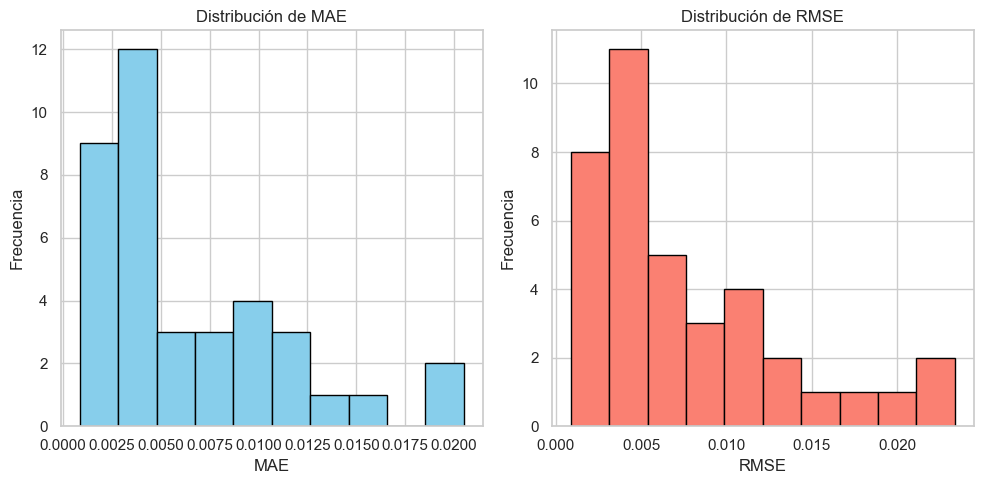

In [153]:
# Plotear los resultados
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(df_depo['MAE'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribución de MAE')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
plt.hist(df_depo['RMSE'], bins=10, color='salmon', edgecolor='black')
plt.title('Distribución de RMSE')
plt.xlabel('RMSE')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

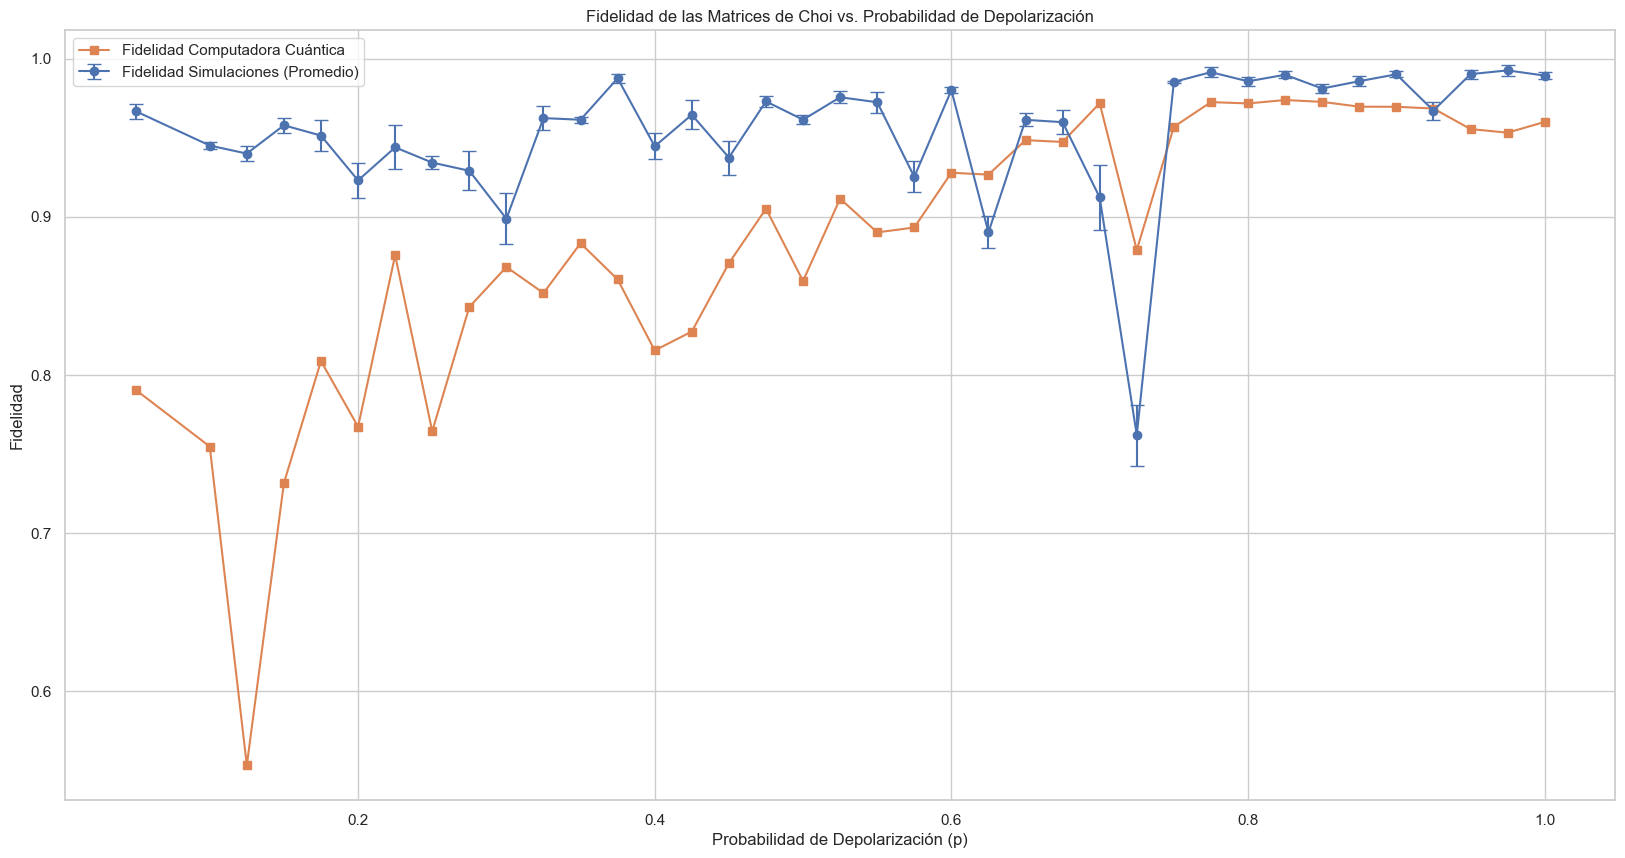

In [154]:
# Plotear la fidelidad promedio con gajos de error
plt.figure(figsize=(20,10))

plt.errorbar(df_depo['p'], df_depo['Fidelidad_prom'], yerr=df_depo['MAE'], fmt='-o', label='Fidelidad Simulaciones (Promedio)', capsize=5)
plt.plot(df_depo['p'], df_depo['Fidelidad_qc'], '-s', label='Fidelidad Computadora Cuántica')

plt.title('Fidelidad de las Matrices de Choi vs. Probabilidad de Depolarización')
plt.xlabel('Probabilidad de Depolarización (p)')
plt.ylabel('Fidelidad')
plt.legend()
plt.grid(True)
plt.show()

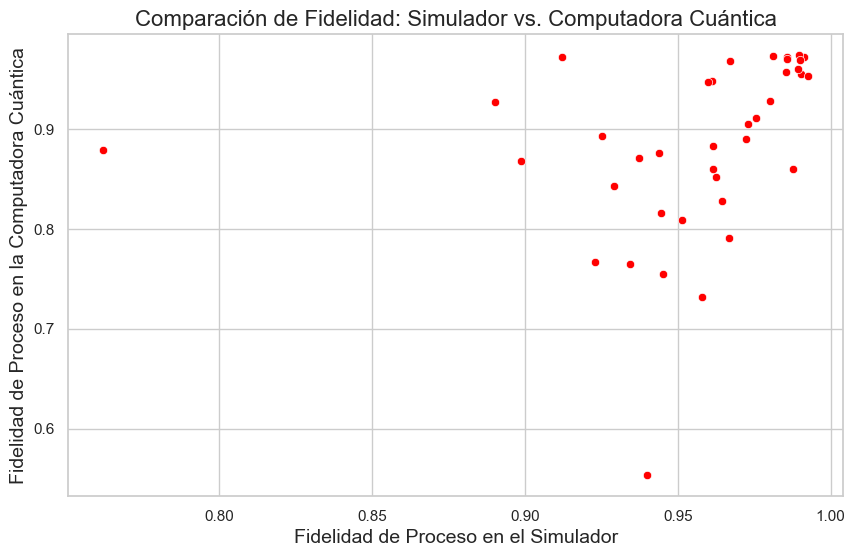

In [155]:
# Configuración del estilo visual de Seaborn
sns.set(style="whitegrid")

# Creación del gráfico de regresión con Seaborn, que incluye tanto los puntos como la línea de regresión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Fidelidad_prom', y='Fidelidad_qc', data=df_depo, color='red') # scatter_kws permite personalizar los puntos

# Añadiendo detalles al gráfico
plt.title('Comparación de Fidelidad: Simulador vs. Computadora Cuántica', fontsize=16)
plt.xlabel('Fidelidad de Proceso en el Simulador', fontsize=14)
plt.ylabel('Fidelidad de Proceso en la Computadora Cuántica', fontsize=14)
plt.grid(True)

# Mostrar el gráfico
plt.show()

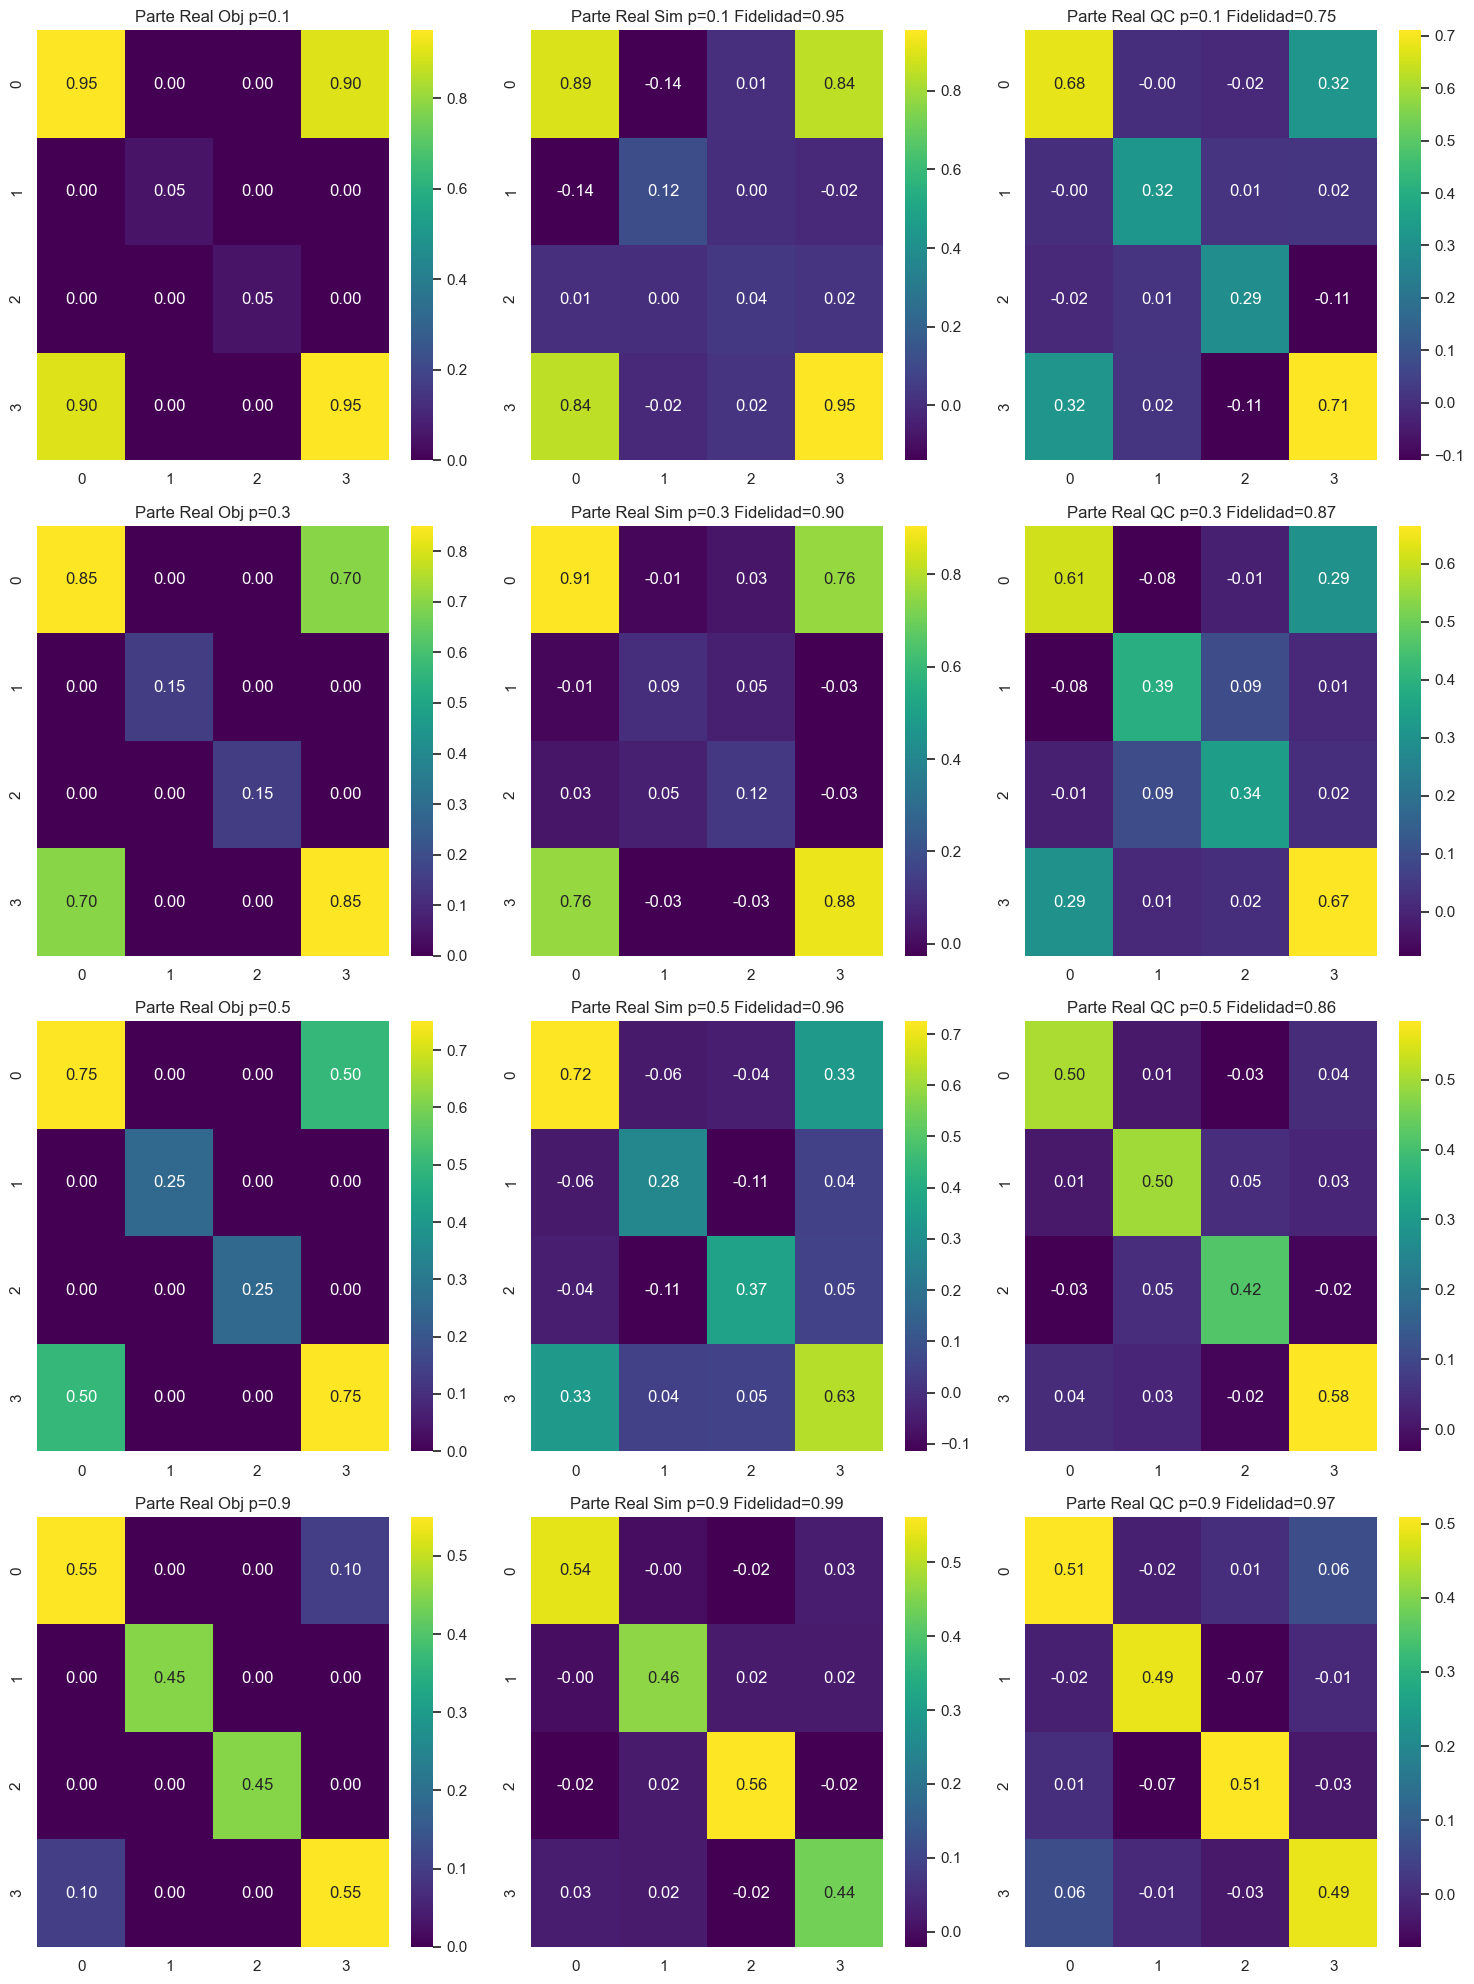

In [158]:
# Definimos los valores de p a graficar
p_values_to_plot = [0.1, 0.3, 0.5, 0.9]
filtered_rows = df_depo[df_depo['p'].isin(p_values_to_plot)]

# Configuración de la figura
num_p = len(p_values_to_plot)
plt.figure(figsize=(15, 5 * num_p))

for idx, (index, row) in enumerate(filtered_rows.iterrows()):
    # Convertir las matrices de Choi a arrays reales
    real_part_obj = np.real(row['Choi_obj'])
    real_part_sim = np.real(row['Choi_sim_1'])
    real_part_qc = np.real(row['Choi_qc'])
    
    # Subplot para la matriz objetivo
    plt.subplot(num_p, 3, 3 * idx + 1)
    sns.heatmap(real_part_obj, annot=True, cmap='viridis', fmt=".2f")
    plt.title(f'Parte Real Obj p={row["p"]}')
    
    # Subplot para la matriz del simulador
    plt.subplot(num_p, 3, 3 * idx + 2)
    sns.heatmap(real_part_sim, annot=True, cmap='viridis', fmt=".2f")
    plt.title(f'Parte Real Sim p={row["p"]} Fidelidad={row["Fidelidad_sim_1"]:.2f}')
    
    # Subplot para la matriz de la computadora cuántica
    plt.subplot(num_p, 3, 3 * idx + 3)
    sns.heatmap(real_part_qc, annot=True, cmap='viridis', fmt=".2f")
    plt.title(f'Parte Real QC p={row["p"]} Fidelidad={row["Fidelidad_qc"]:.2f}')
    
plt.tight_layout()
plt.show()